# Inference tests

In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import matplotlib.pyplot as plt
import numpy as np
from corner import corner
from jax import numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, init_to_median

import rcfit

SPARC = rcfit.SPARCReader("../data/SPARC.h5")
SPARC.print_nsamples_per_curve()

%load_ext autoreload
%autoreload 2


/mnt/users/rstiskalek/RCfit/venv_rcfit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Rotation curves are sampled with this many points:
UGC02953   113
NGC2403    72
UGC05253   72
UGC06787   68
UGC09133   67
UGC11914   61
NGC6946    54
NGC2841    50
UGC03205   46
NGC6015    44
UGC02916   41
UGC06786   41
UGC03580   39
UGC08699   38
NGC3198    37
NGC7331    36
NGC4013    36
UGC11455   35
NGC1003    35
NGC3521    34
NGC5985    33
NGC2903    32
IC4202     31
UGC08490   30
NGC6503    30
NGC4559    29
ESO563-G021 28
UGC12506   28
NGC5055    27
UGC07524   27
DDO161     26
NGC0247    26
NGC7793    25
NGC4100    24
NGC2955    24
NGC6195    23
NGC5585    23
UGC03546   22
NGC5033    22
IC2574     22
NGC0289    22
NGC1090    22
NGC2915    21
NGC3109    21
NGC2976    21
UGC00128   21
NGC0024    20
NGC0055    20
UGC09037   20
NGC4183    20
UGC05721   20
NGC5907    19
NGC5371    19
UGC02885   19
NGC3741    19
NGC0891    18
NGC4217    18
NGC7814    18
UGC02487   17
NGC5005    17
NGC0300    16
NGC4157    16
NGC3917    16
UGC08286   16
UGC12732   16
NGC0100    16
UGC05986   15
UGC06983 

Fit a selected galaxy to a model `kind`

In [2]:
galaxy_name = "UGC08490"
galaxy_data = SPARC(galaxy_name)

nuts_kernel = NUTS(rcfit.SPARC_independent, init_strategy=init_to_median(num_samples=10000))
mcmc = MCMC(nuts_kernel, num_warmup=2500, num_samples=5000)
mcmc.run(random.PRNGKey(0), galaxy_data=galaxy_data, kind="NFW")
mcmc.print_summary()


samples = mcmc.get_samples()
log_likelihood = samples.pop("log_likelihood")

print(f"BIC: {rcfit.BIC_from_samples(samples, log_likelihood)}")

sample: 100%|██████████| 7500/7500 [00:05<00:00, 1299.18it/s, 31 steps of size 1.27e-01. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           L36      1.02      0.01      1.02      1.00      1.04   4852.15      1.00
          dist      5.05      0.47      5.06      4.27      5.79   3601.34      1.00
           inc      0.95      0.05      0.95      0.88      1.03   3380.48      1.00
      logM200c     10.61      0.07     10.60     10.49     10.71   2348.84      1.00
  log_Ups_disk     -0.25      0.09     -0.25     -0.41     -0.11   3723.62      1.00
   log_Ups_gas      0.00      0.04      0.00     -0.06      0.07   5077.54      1.00
          logc      1.23      0.07      1.23      1.11      1.35   2746.68      1.00

Number of divergences: 0
BIC: 152.29588317871094


Plot the observed rotation curve

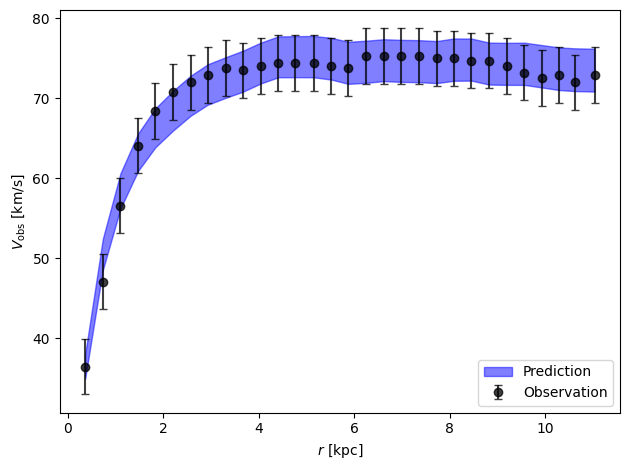

In [3]:
plt.figure()
plt.errorbar(np.median(samples["r"], axis=0), np.median(samples["Vobs"], axis=0),
             np.median(samples["e_Vobs"], axis=0), fmt="o", capsize=3,
             color="black", alpha=0.75, label="Observation")


ylow, yhigh = np.percentile(samples["Vpred"], [16, 84], axis=0)
plt.fill_between(np.median(samples["r"], axis=0), ylow, yhigh,
                 color="blue", alpha=0.5, label="Prediction")

plt.legend()
plt.xlabel(r"$r ~ [\mathrm{kpc}]$")
plt.ylabel(r"$V_{\rm obs} ~ [\mathrm{km} / \mathrm{s}]$")

plt.tight_layout()
plt.savefig(f"../plots/rotation_curve_{galaxy_name}.png", dpi=450)
plt.show()

Plot a corner plot of the posterior samples.

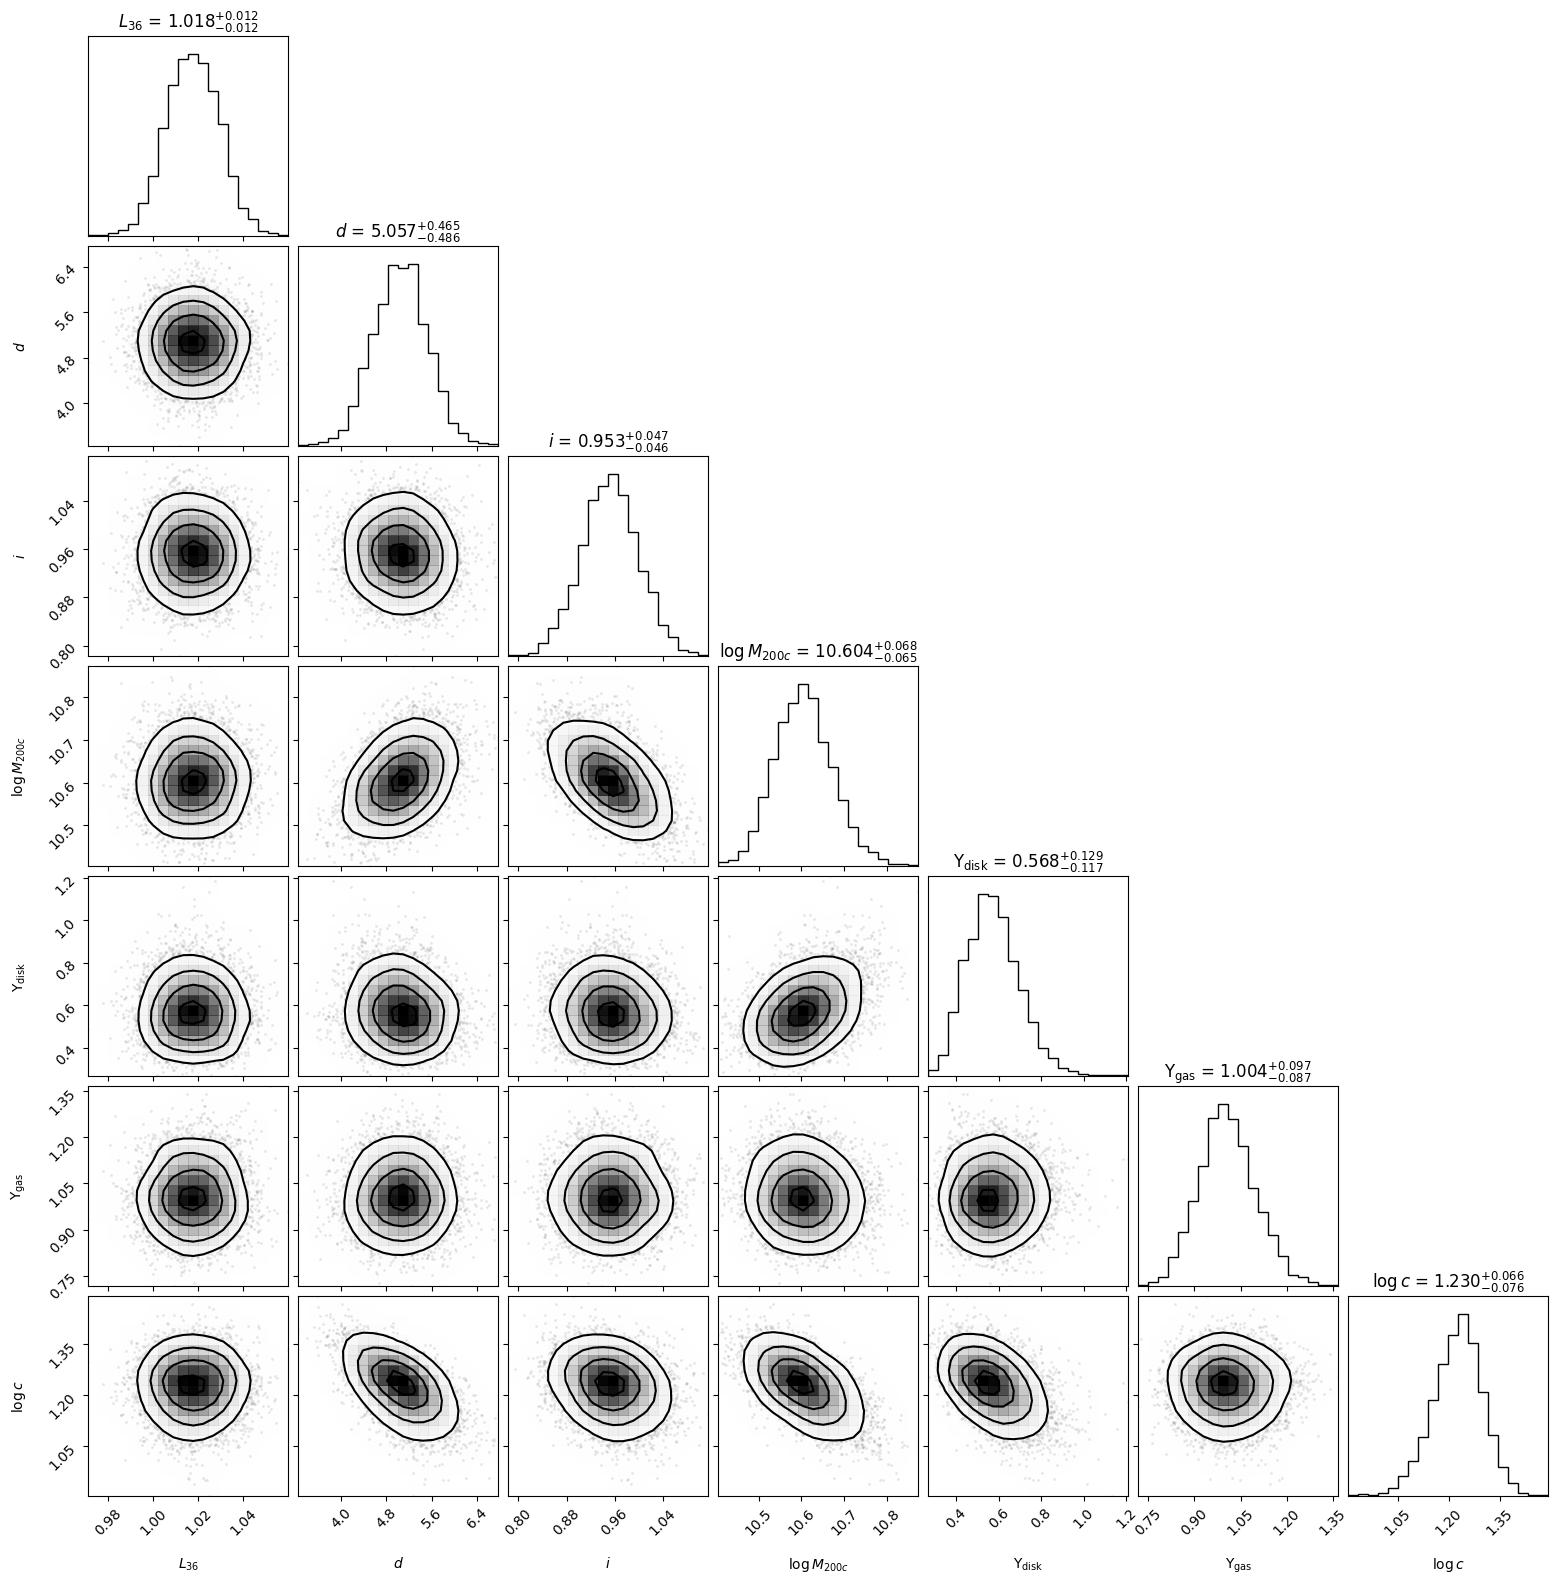

In [4]:
labels = list(samples.keys())
for p in ("Vpred", "Vobs", "e_Vobs", "r", "alpha", "beta"):
    try:
        labels.remove(p)
    except ValueError:
        pass
if not galaxy_data["has_bulge"]:
    labels.remove("log_Ups_bulge")

data = np.vstack([samples[label] for label in labels]).T

for key in ["log_Ups_disk", "log_Ups_bulge", "log_Ups_gas"]:
    if key in labels:
        k = labels.index(key)
        data[:, k] = 10**data[:, k]
        labels[k] = key.replace("log_", "")

names = [rcfit.name2label(label) for label in labels]

fig = corner(data, labels=names, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()